In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [2]:
import arviz as az
from emcee import EnsembleSampler
import matplotlib.pyplot as plt
from multiprocessing import Pool
import numpy as np
import pymc3 as pm
import pymc3_ext as pmx
import scipy.linalg as sl
import scipy.stats as ss
import starry
from starry import Map, System, Primary, Secondary
import starry_process
from starry_process import StarryProcess
import theano
theano.config.gcc__cxxflags += " -fexceptions"
theano.config.on_opt_error = "raise"
theano.tensor.opt.constant_folding
theano.graph.opt.EquilibriumOptimizer
import theano.tensor as tt
from theano.tensor.random.utils import RandomStream
from tqdm.notebook import tqdm
from corner import corner

WARNING (theano.link.c.cmodule): install mkl with `conda install mkl-service`: No module named 'mkl'


Formulas:
$$
N\left( f \mid M y, C \right) N\left( y \mid \mu, \Lambda \right) = N\left( y \mid a, A \right) N\left( f \mid b, B \right)
$$
where
$$
A^{-1} = \Lambda^{-1} + M^T C^{-1} M
$$
$$
a = A \left( \Lambda^{-1} \mu + M^T C^{-1} M f \right)
$$
$$
b = M \mu
$$
$$
B = C + M \Lambda M^T
$$

Useful re-writing:
$$
A = \left( I + \Lambda M^T C^{-1} M \right)^{-1} \Lambda
$$

$$
B^{-1} = C^{-1} - C^{-1} M \left( I + \Lambda M^T C^{-1} M \right)^{-1} \Lambda M^T C^{-1}
$$

In [3]:
def _cho_solve(L, b):
    return tt.slinalg.solve_upper_triangular(L.T, tt.slinalg.solve_lower_triangular(L, b))

class StarryStarryProcess(object):
    def __init__(self, sys, sp, nt, nlm, t):
        self._sys = sys
        self._sp = sp
        self._nt = nt
        self._nlm = nlm

        self._mu = sp.mean_ylm
        self._Lambda = sp.cov_ylm

        self._t = t

        self._K = sp.temporal_kernel(t, t, sp.tau) # this will be of shape (nt, nt)

    @property
    def nt(self):
        return self._nt
    @property
    def nlm(self):
        return self._nlm

    @property
    def sys(self):
        return self._sys
    @property
    def sp(self):
        return self._sp
    
    @property
    def mu(self):
        return self._mu
    @property
    def Lambda(self):
        return self._Lambda
    
    @property
    def primary(self):
        return self.sys.primary
    @property
    def secondary(self):
        return self.sys.secondaries[0]
    
    @property
    def design_matrix(self):
        return self._M
    
    @property
    def temp_kernel(self):
        return self._K
    
    @property
    def temp_kernel_chol(self):
        k = tt.slinalg.cholesky(self._K)
        return k
    
    @property
    def logl_marginal(self):
        return self._logl_marginal
    @property
    def a(self):
        return self._a
    @property
    def AInv_chol(self):
        return self._AInv_chol

    def _compute(self, t, flux, sigma_flux, temporal=True):
        M = self.sys.design_matrix(t)[:,:-1] # We don't use any flux from the secondary, so [:, :-1], the shape is (nt, nlm)
        self._M = M

        nlm = self.nlm
        nt = self.nt

        mu = self.mu
        Lambda = self.Lambda # covariance of the spherical harmonic, the shape is (nlm, nlm)

        # if temporal then the ylm covariance matrix should become \Lambda *Kronecker product* K:
        # if temporal: 
        #     K = self._K # the temporal kernel
        #     Lambda = tt.dot(Lambda, K) # the shapes don't match 

        # We want to enforce that the prior on the constant term in the map is
        # completely flat, so we set the first row and column of the precision
        # matrix to zero we do this manually here.  First we Cholesky decompose:
        #
        # Lambda[1:,1:] = L L^T
        #
        # Then, because of a quirk of theano (no gradients for `cho_solve!`,
        # WTF), we can compute Lambda[1:,1:]^{-1} via
        #
        # Lambda[1:,1:]^{-1} = tt.slinalg.solve_triangular(L.T, tt.slinalg.solve_triangular(L, tt.eye(nlm-1), lower=True), lower=False)
        #
        # encapsulated in our _cho_solve(...) function above

        L0 = tt.slinalg.cholesky(Lambda[1:,1:])
        K = self.temp_kernel_chol.eval()
        L = tt.dot(L0, K)*tt.dot(tt.transpose(L0), tt.transpose(K))
        Lambda_inv = _cho_solve(L, tt.eye(nlm-1))
        Lambda_inv = tt.set_subtensor(tt.zeros((nlm, nlm))[1:,1:], Lambda_inv)


        sigma_flux2 = tt.square(sigma_flux)
        MTCinv = M.T / sigma_flux2[None, :]
        MTCinvM = tt.dot(MTCinv, M)

        AInv = Lambda_inv + MTCinvM
        AInv_chol = tt.slinalg.cholesky(AInv)
        a = _cho_solve(AInv_chol, tt.dot(Lambda_inv, mu) + tt.dot(MTCinv, flux))

        self._a = a
        self._AInv_chol = AInv_chol

        b = tt.dot(M, mu)
        r = flux - b

        Cinvr = r / sigma_flux2

        rtilde = Cinvr - tt.dot(MTCinv.T, tt.slinalg.solve(AInv, tt.dot(MTCinv, r)))

        # Identity:
        # |B| = |I + M^T C^-1 M L| |C| = |L^-1 + M^T C^-1 M| |L| |C|
        # But we want to cancel the infinite constant in L[0,0], so we ignore the first row and column of L:
        # |B| = | A^-1 | |L[1:,1:]| |C|


        logdetB = tt.sum(tt.log(sigma_flux2)) + 2*tt.sum(tt.log(tt.diag(AInv_chol))) + 2*tt.sum(tt.log(tt.diag(L)))

        if temporal:
            K = self._K
            logdetB = logdetB + tt.nlinalg.Det(K)

        # (nt-1) because we have cancelled one dimension due to the flat prior on the [0,0] constant term.
        logl = -0.5*tt.dot(r, rtilde) - 0.5*logdetB - 0.5*(nt-1)*tt.log(2*np.pi)
        self._logl_marginal = logl

    def marginal_likelihood(self, t, flux, sigma_flux, temporal):
        self._compute(t, flux, sigma_flux, temporal=temporal)
        return self.logl_marginal
    
    def sample_ylm_conditional(self, t, flux, sigma_flux, size=1, rng=None, temporal=False):
        if rng is None:
            rng = RandomStream(seed=np.random.randint(1<<32))

        nylm = self.nlm

        self._compute(t, flux, sigma_flux, temporal=temporal)
        return self.a[None,:] + tt.slinalg.solve_upper_triangular(self.AInv_chol.T, rng.normal(size=(nylm, size))).T

In [12]:
starry.config.lazy = True

ydeg = 15
udeg = 2

u1 = 0.4
u2 = 0.26

r = 20.0
dr = 5.0
n = 1
c = 0.5
mu = 30.0
sigma = 5.0
tau = 25.0

nt = 1000

rng = np.random.default_rng(302592346730275158208684369480422136411)

pri = Primary(starry.Map(ydeg, udeg=udeg),
              r=0.683, m=0.81, prot=30.0, t0=0.0)
sec = Secondary(starry.Map(0, 0), 
                t0=0, r=0.2, m=0.1, prot=1.0,
                porb=4.887802443, ecc=0.0, Omega=30.0)
pri.map[1] = u1
pri.map[2] = u2


t = np.linspace(-100*sec.porb.eval(), 100*sec.porb.eval(), nt)

sys = System(pri, sec)

sp = StarryProcess(n=n, mu=mu, sigma=sigma, r=r, dr=dr, ydeg=ydeg, udeg=udeg, tau=tau, marginalize_over_inclination=False, seed=rng.integers(0, 1<<32))

ssp = StarryStarryProcess(sys, sp, nt, len(pri.map.y.eval()), t)

y_true = sp.sample_ylm(t).eval().reshape(nt, 256)
y_true[:,0] = 1.0

flux_true = sys.design_matrix(t).eval()[:, :-1] @ y_true.T

sigma_flux = 0.005*np.ones_like(flux_true)

flux_obs = flux_true + sigma_flux*rng.normal(size=nt)

Pre-computing some matrices... Done.
Pre-computing some matrices... Done.


In [13]:
flux_obs.shape

(1000, 1000)

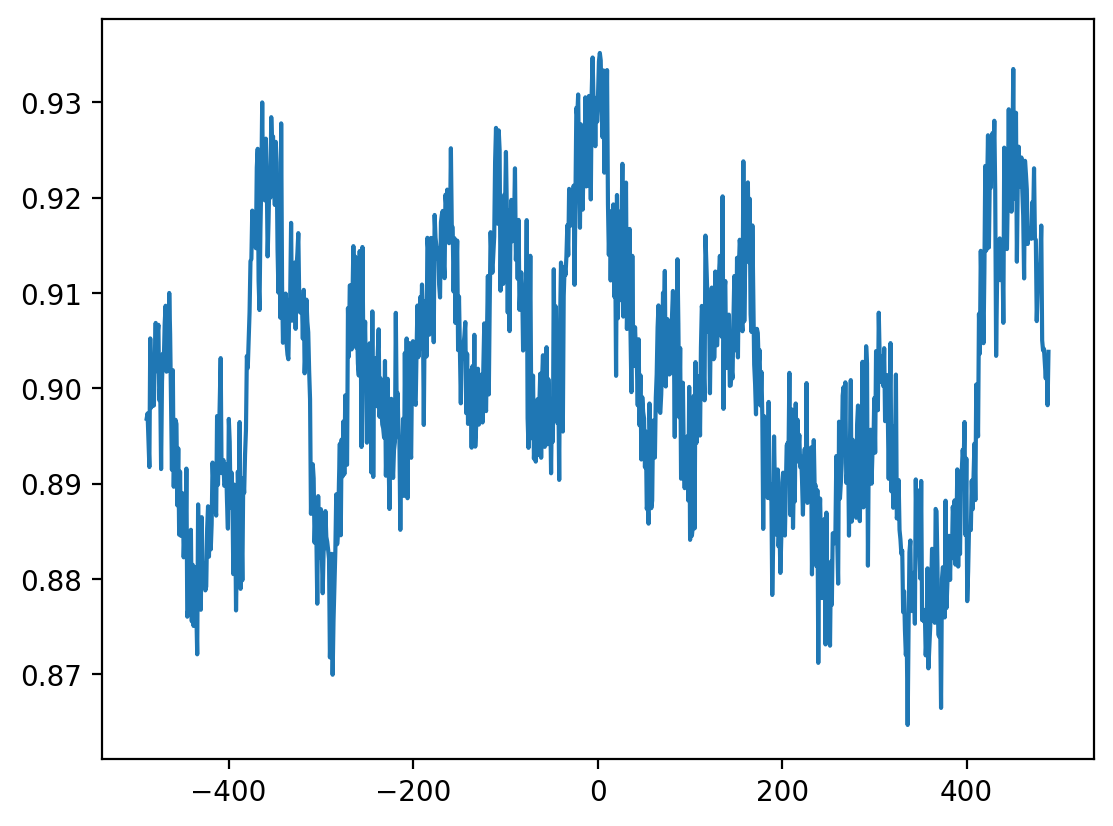

In [14]:
plt.plot(t, flux_obs[0])

<ErrorbarContainer object of 3 artists>

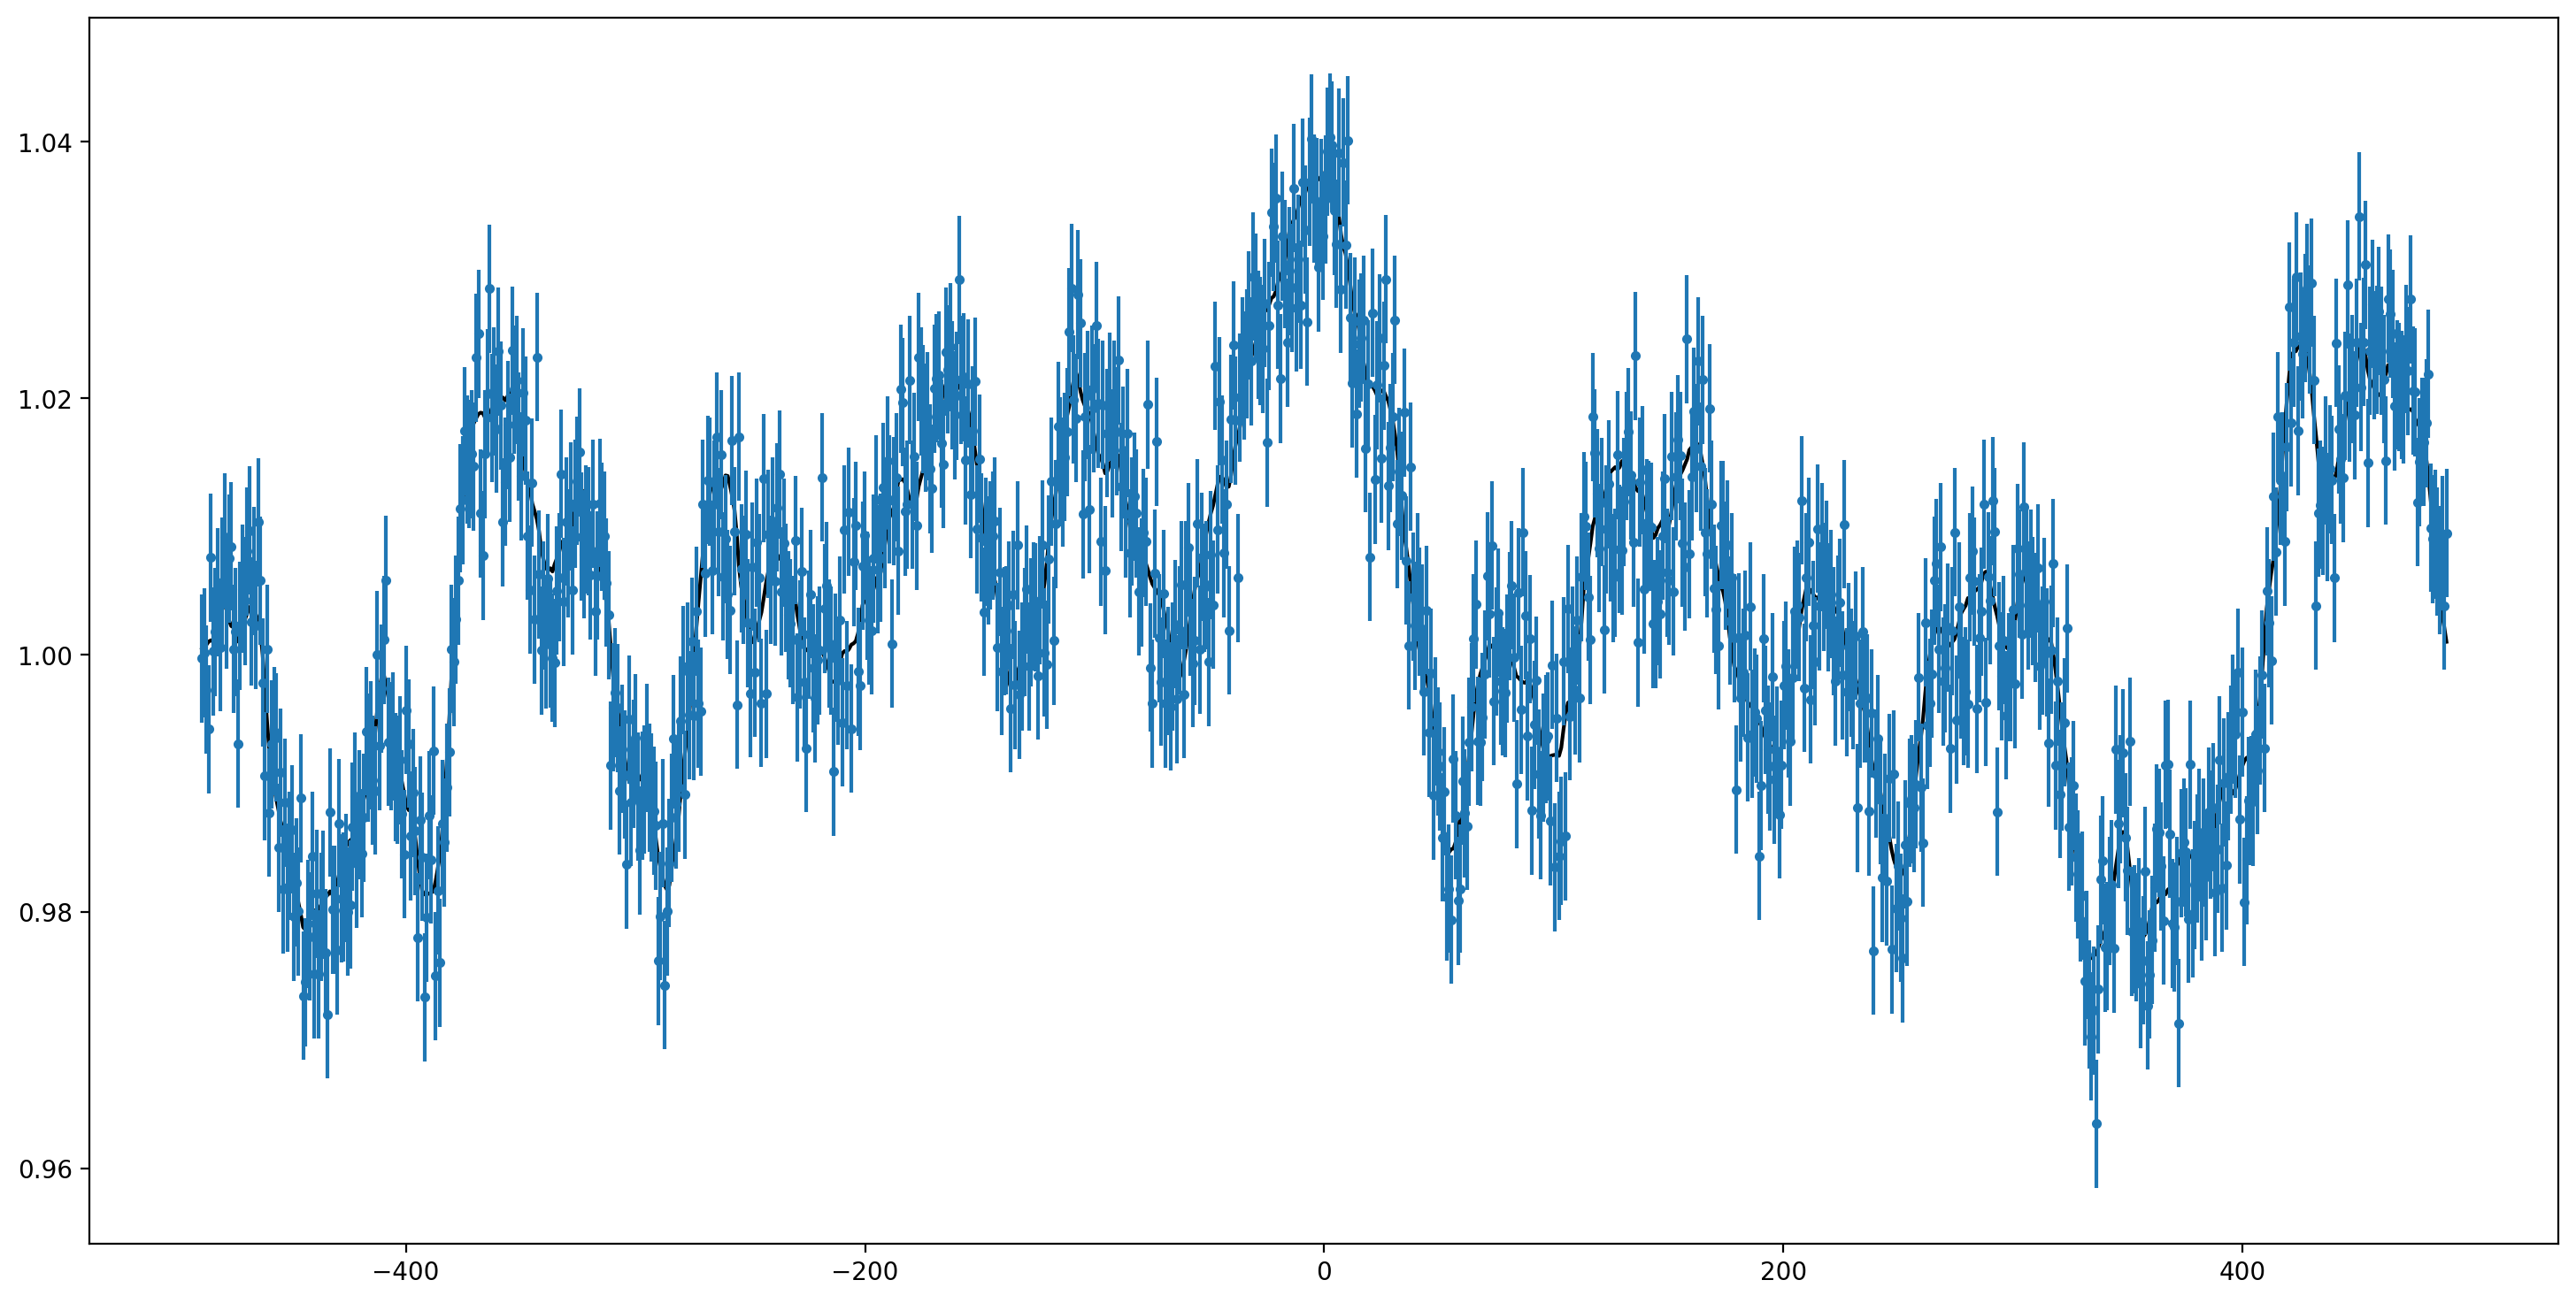

In [17]:
plt.figure(figsize=(18,9))
plt.plot(t, flux_true[1], color='k')
plt.errorbar(t, flux_obs[1], yerr=sigma_flux[:,0], fmt='.')

In [18]:
t

array([-488.7802443 , -487.80170527, -486.82316624, -485.84462722,
       -484.86608819, -483.88754916, -482.90901013, -481.93047111,
       -480.95193208, -479.97339305, -478.99485402, -478.016315  ,
       -477.03777597, -476.05923694, -475.08069791, -474.10215889,
       -473.12361986, -472.14508083, -471.1665418 , -470.18800278,
       -469.20946375, -468.23092472, -467.25238569, -466.27384666,
       -465.29530764, -464.31676861, -463.33822958, -462.35969055,
       -461.38115153, -460.4026125 , -459.42407347, -458.44553444,
       -457.46699542, -456.48845639, -455.50991736, -454.53137833,
       -453.55283931, -452.57430028, -451.59576125, -450.61722222,
       -449.63868319, -448.66014417, -447.68160514, -446.70306611,
       -445.72452708, -444.74598806, -443.76744903, -442.78891   ,
       -441.81037097, -440.83183195, -439.85329292, -438.87475389,
       -437.89621486, -436.91767584, -435.93913681, -434.96059778,
       -433.98205875, -433.00351973, -432.0249807 , -431.04644

In [21]:
from numpy.polynomial.chebyshev import chebfit, chebval

# Degree of the Chebyshev polynomial for fitting
degree = 3  # You can adjust this based on your data

cheb_coeffs = chebfit(t, flux_obs[0], degree)

def cheb_extrapolate(cheb_coeffs, time):
    return chebval(time, cheb_coeffs)

new_time = 500.0  
extrapolated_flux = cheb_extrapolate(cheb_coeffs, new_time)

print(f"Extrapolated flux at time {new_time}: {extrapolated_flux}")


Extrapolated flux at time 500.0: 0.9087911737834287


In [5]:
y_true.shape

(10, 256)

In [6]:
nt

10

In [7]:
def linear_interpolate_sets(ylm_matrix, times, t_k):

    idx = np.argmin(np.abs(times - t_k))

    if idx >= len(times)-1:
        idx -= 1 
    
    t_low = times[idx]
    t_high = times[idx + 1]

    interpolation_coeff = (t_k - t_low) / (t_high - t_low)
    
    ylm_low = ylm_matrix[idx]
    ylm_high = ylm_matrix[idx + 1]
    
    interpolated_set = ylm_low + (ylm_high - ylm_low) * interpolation_coeff
    
    return interpolated_set, (1 - interpolation_coeff, interpolation_coeff)


nt = len(t)  
nylm = 256  

t_k = 5.5 

interpolated_set, interpolation_coefficients = linear_interpolate_sets(y_true, t, t_k)
interpolated_sets = []
interpolated_coeffs = []

for time in t:
    interpolated_set, interpolation_coefficients = linear_interpolate_sets(y_true, t, time)
    interpolated_sets.append(interpolated_set)
    interpolated_coeffs.append(interpolation_coefficients)

interpolated_coeffs = np.array(interpolated_coeffs)
interpolated_sets = np.array(interpolated_sets)

In [9]:
A_starry = sys.design_matrix(t).eval()[:,:-1]

In [10]:
A_starry.shape

(10, 256)

In [12]:
interpolated_coeffs.shape

(10, 2)

In [78]:
A_new = np.kron(A_starry, interpolated_coeffs)

In [40]:
y_true

array([[ 1.00000000e+00, -6.69493627e-03, -8.92066323e-03, ...,
        -1.26925945e-04, -1.15593719e-03, -3.07478757e-04],
       [ 1.00000000e+00, -2.18458092e-03, -3.69720715e-05, ...,
        -6.16806796e-04,  3.67988174e-04, -5.08334024e-04],
       [ 1.00000000e+00, -1.04793492e-02, -6.06166538e-04, ...,
         1.15238422e-04, -9.58540754e-04,  1.49499897e-04],
       ...,
       [ 1.00000000e+00, -7.12886708e-03,  8.95777833e-03, ...,
        -8.82670823e-04,  2.50968177e-04, -2.73096525e-04],
       [ 1.00000000e+00,  2.04341631e-03, -7.58943077e-03, ...,
         1.21487947e-03,  4.44964555e-04, -9.88525428e-05],
       [ 1.00000000e+00,  5.43721250e-04,  1.32861724e-02, ...,
        -2.22532745e-04, -5.94591226e-06, -3.35197907e-04]])

In [15]:
K = sp.temporal_kernel(t,t,sp.tau).eval()

In [18]:
K.shape

(10, 10)

In [16]:
L = ssp.Lambda.eval()

In [19]:
L.shape

(256, 256)

In [7]:
K_chol = tt.slinalg.cholesky(K).eval()

In [8]:
L_chol = tt.slinalg.cholesky(L).eval()

In [9]:
np.kron(K_chol, L_chol).shape

(25600, 25600)

In [26]:
y_true.shape

(1000, 256)

In [27]:
flux_true.shape

(1000, 1000)

In [5]:
ssp._K.eval().shape

(1000, 1000)

In [13]:
ssp.temp_kernel_chol

In [17]:
sp.visualize(y_true)

/opt/anaconda3/envs/starry-env/lib/python3.8/site-packages/starry_process/visualize.py:118: RuntimeWarning: invalid value encountered in true_divide
  theta -= (2 * theta + np.sin(2 * theta) - np.pi * np.sin(lat)) / (


<ErrorbarContainer object of 3 artists>

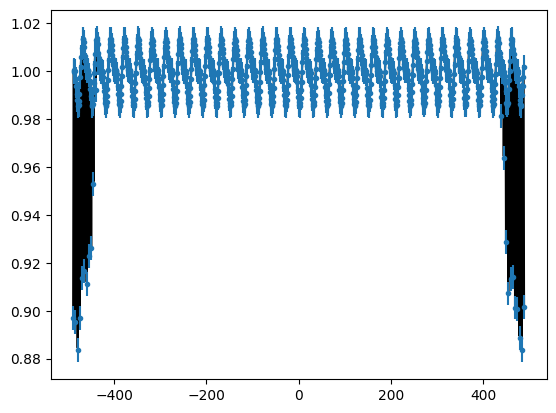

In [29]:
plt.plot(t, flux_true[:,0], color='k')
plt.errorbar(t, flux_obs[:,0], yerr=sigma_flux[:,0], fmt='.')

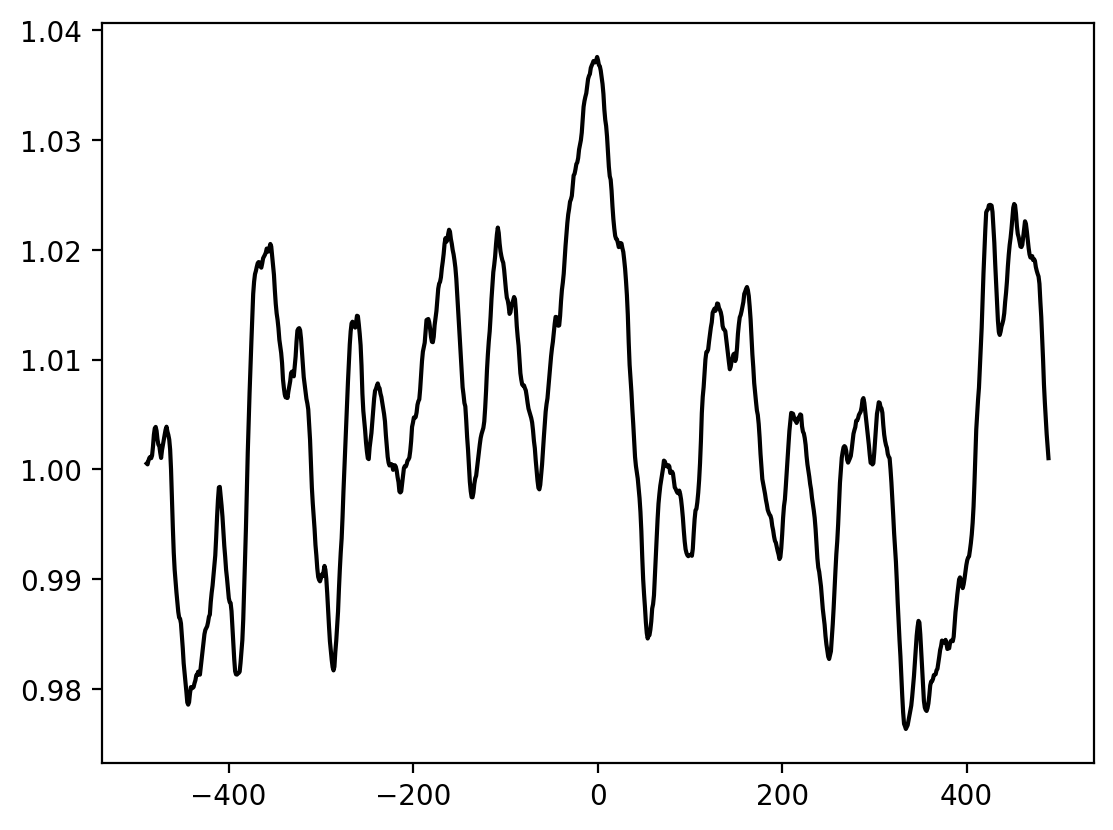

In [7]:
plt.plot(t, flux_true[1], color='k')
# plt.errorbar(t, flux_obs[0], yerr=sigma_flux[0], fmt='.')

(-0.4887802443, 0.4887802443)

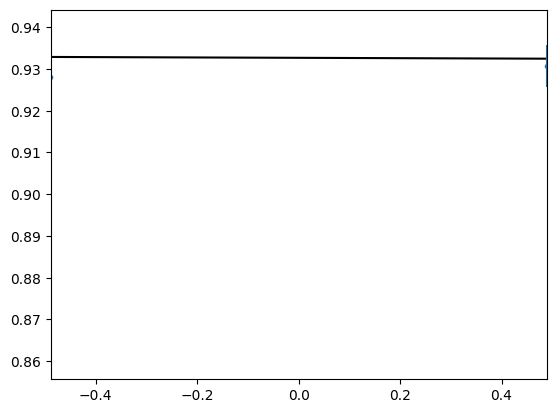

In [32]:
plt.plot(t, flux_true[0], color='k')
plt.errorbar(t, flux_obs[0], yerr=sigma_flux[0], fmt='.')
plt.xlim(-sec.porb.eval()/10, sec.porb.eval()/10)

In [33]:
ylm_draw = ssp.sample_ylm_conditional(t, flux_obs, sigma_flux).eval()[0,:]

ValueError: ('You cannot drop a non-broadcastable dimension.', ([False, False], ['x', 0]))

(-0.4887802443, 0.4887802443)

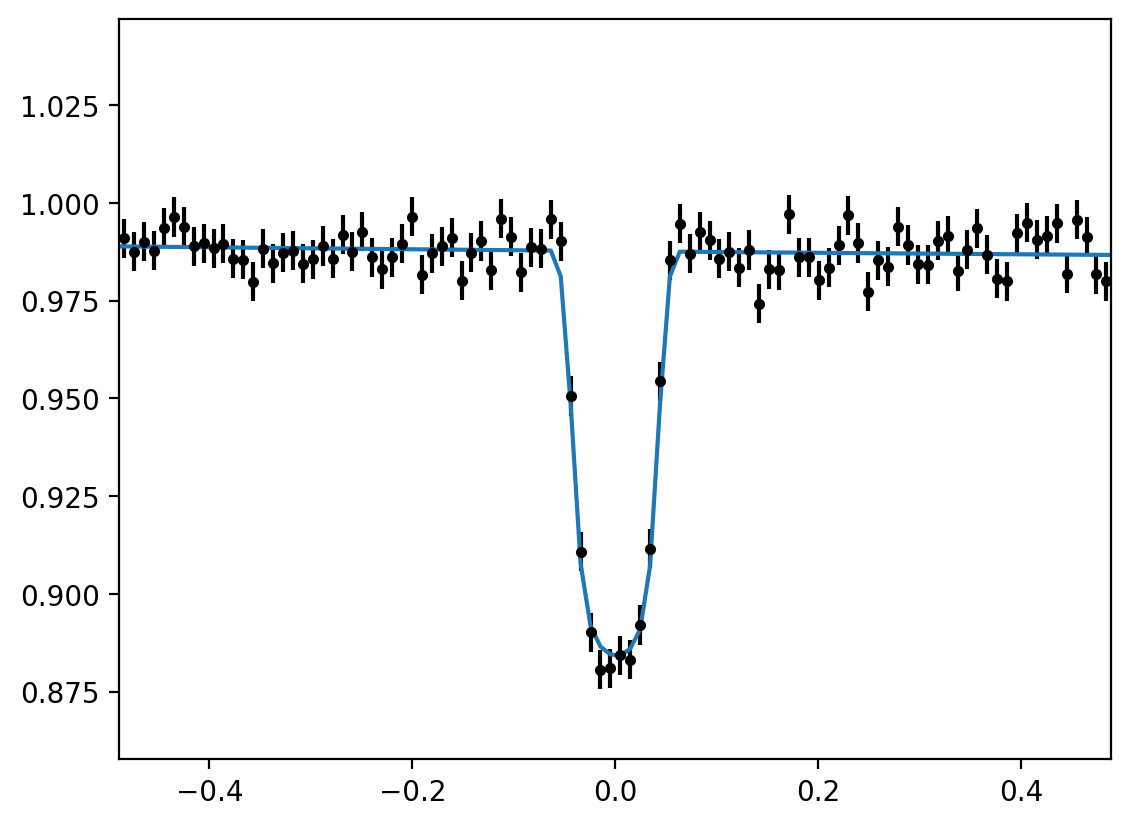

In [9]:
plt.errorbar(t, flux_obs, yerr=sigma_flux, fmt='.', color='k')
plt.plot(t, ssp.design_matrix.eval() @ ssp.a.eval())
plt.xlim(-sec.porb.eval()/10, sec.porb.eval()/10)

Pre-computing some matrices... Done.
Compiling `render`... Done.


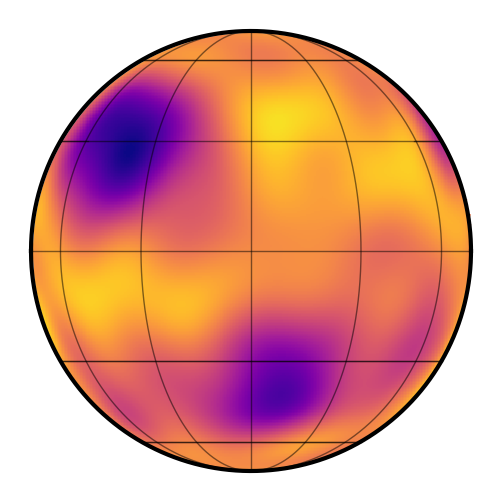

In [21]:
map = starry.Map(ydeg, udeg=udeg)
map[:,:] = y_true
map.show()

In [25]:
xo, yo, zo = sys.position(t)
xo = xo[1].eval()
yo = yo[1].eval()
zo = zo[1].eval()

In [26]:
theta = (360 * t / 10.0) % 360

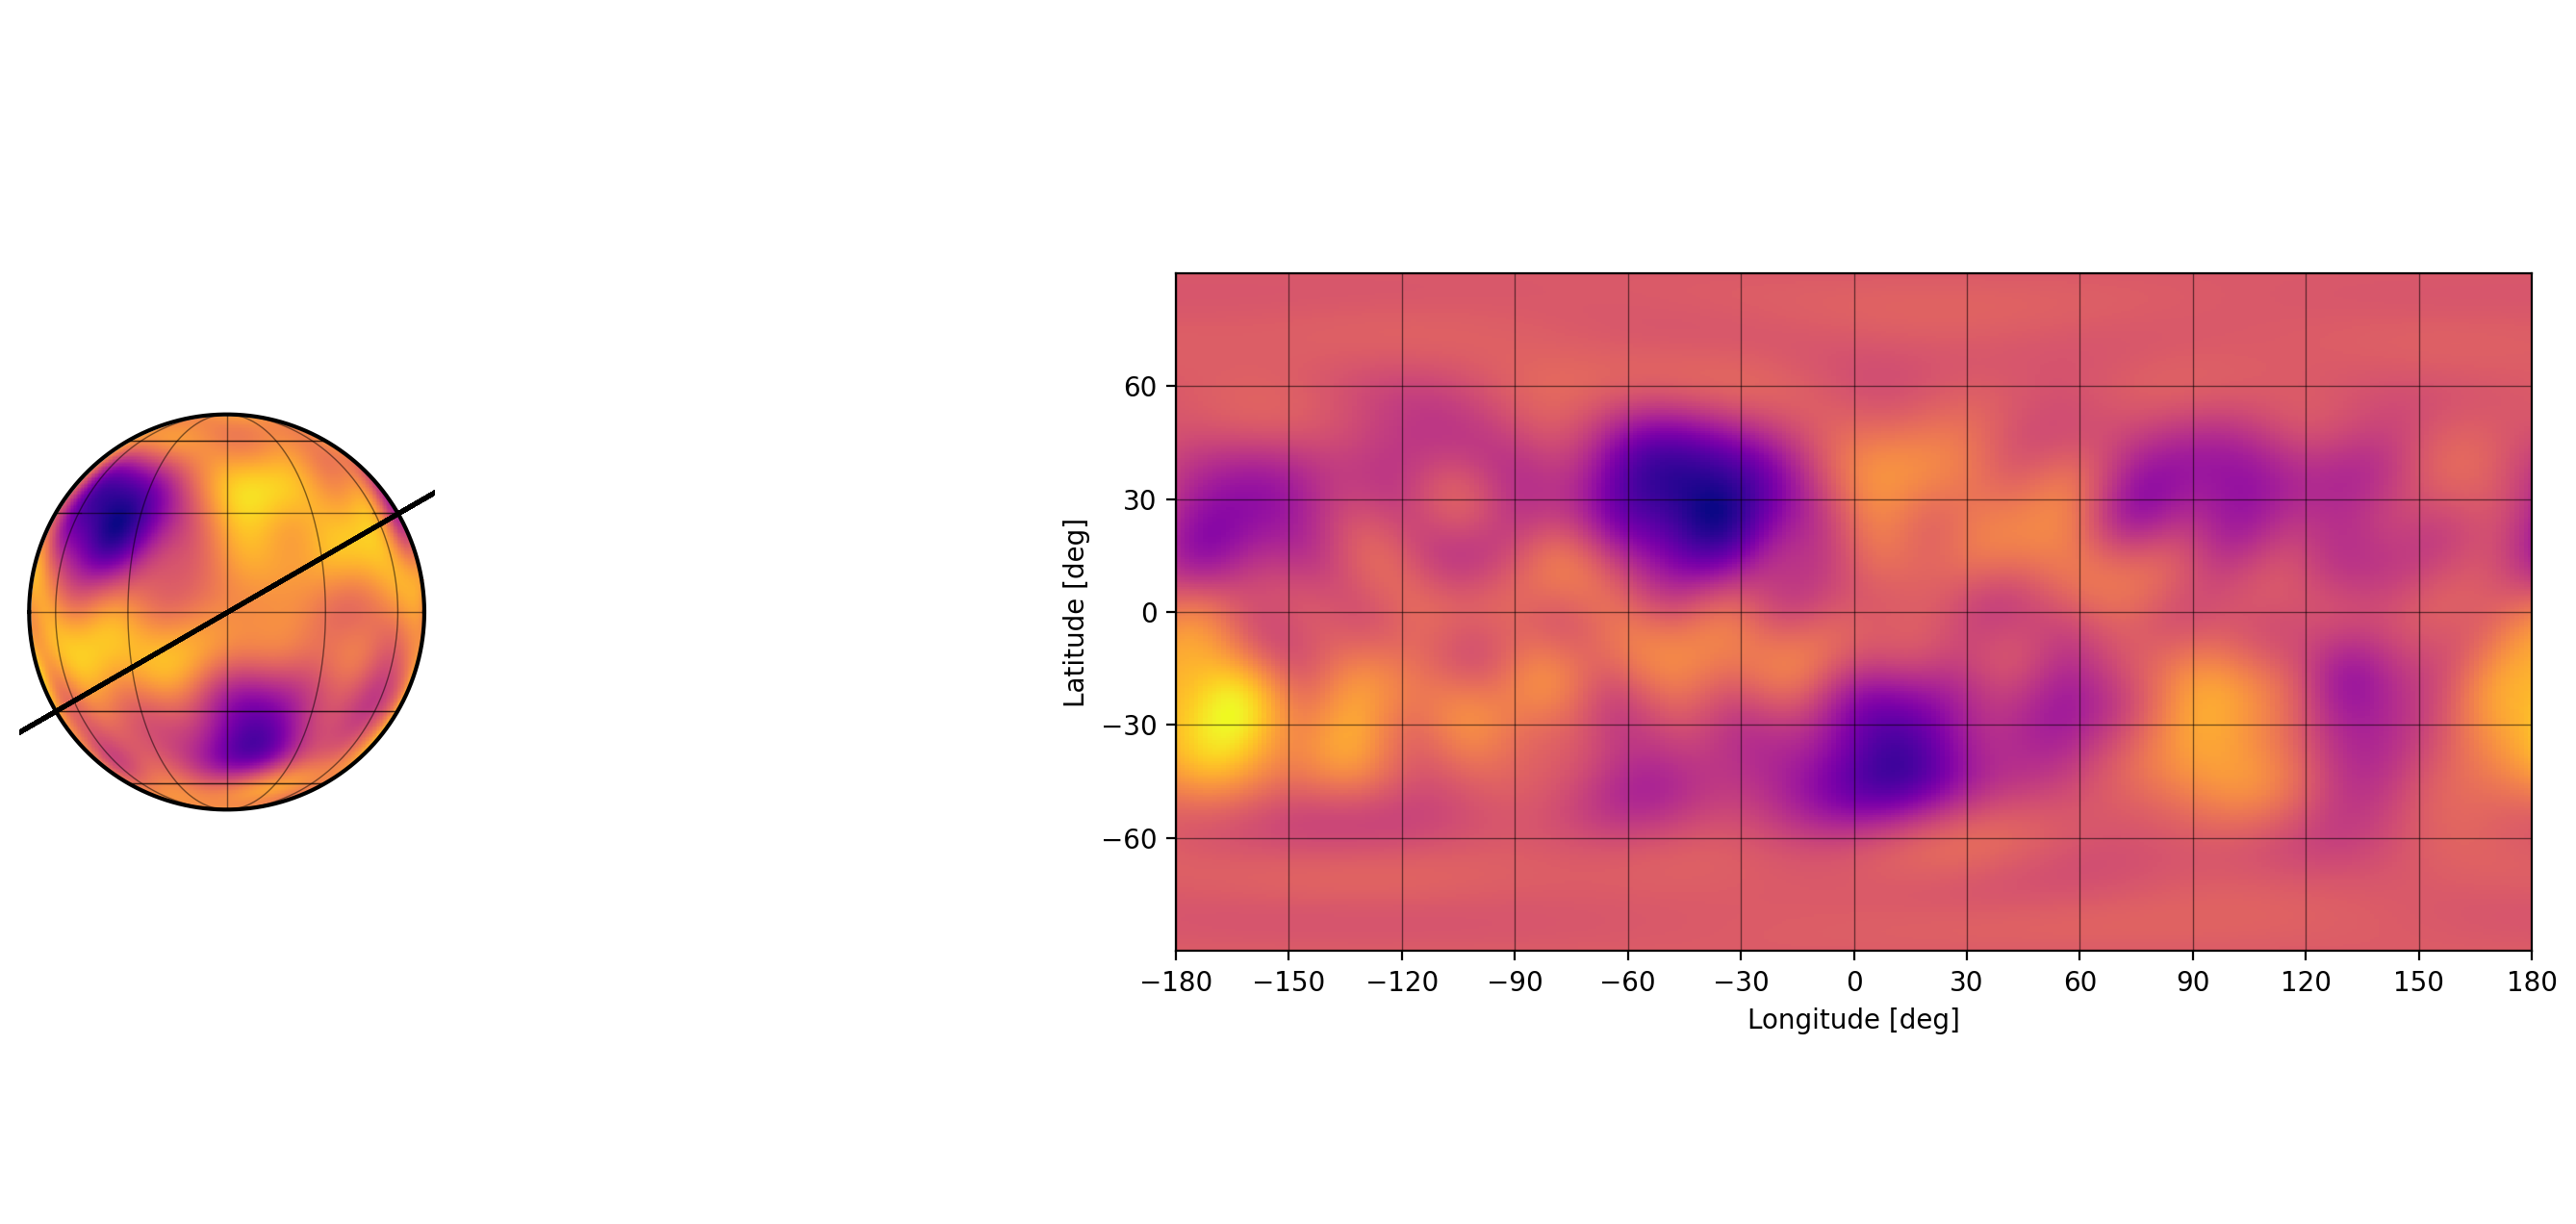

In [29]:
fig, ax = plt.subplots(1, 2, figsize=(20, 8))
idx = (zo > 0) | (xo ** 2 + yo ** 2 > 1)
ax[0].plot(xo[idx], yo[idx], "k.", ms=1);
ax[0].set_aspect(1)
ax[0].axis("off")
# map[:, :] = y
map.show(ax=ax[0])
ax[0].set_ylim(-3, 3)
idx = (zo > 0) & (xo ** 2 + yo ** 2 < 1)
lat = 180 / np.pi * np.arcsin(yo[idx])
lon = 180 / np.pi * np.arcsin(xo[idx] / np.sqrt(1 - yo[idx] ** 2)) - theta[idx]
lon = (lon + 180) % 360 - 180
mask = np.append(np.array(lon[1:] > lon[:-1], dtype=float), 0)
mask[mask == 1] = np.nan
map.show(ax=ax[1], projection="rect")
# ax[1].plot(lon, lat, "k.");

/Users/sabina/Desktop/GitHub/starry_process/starry_process/visualize.py:118: RuntimeWarning: invalid value encountered in true_divide
  theta -= (2 * theta + np.sin(2 * theta) - np.pi * np.sin(lat)) / (


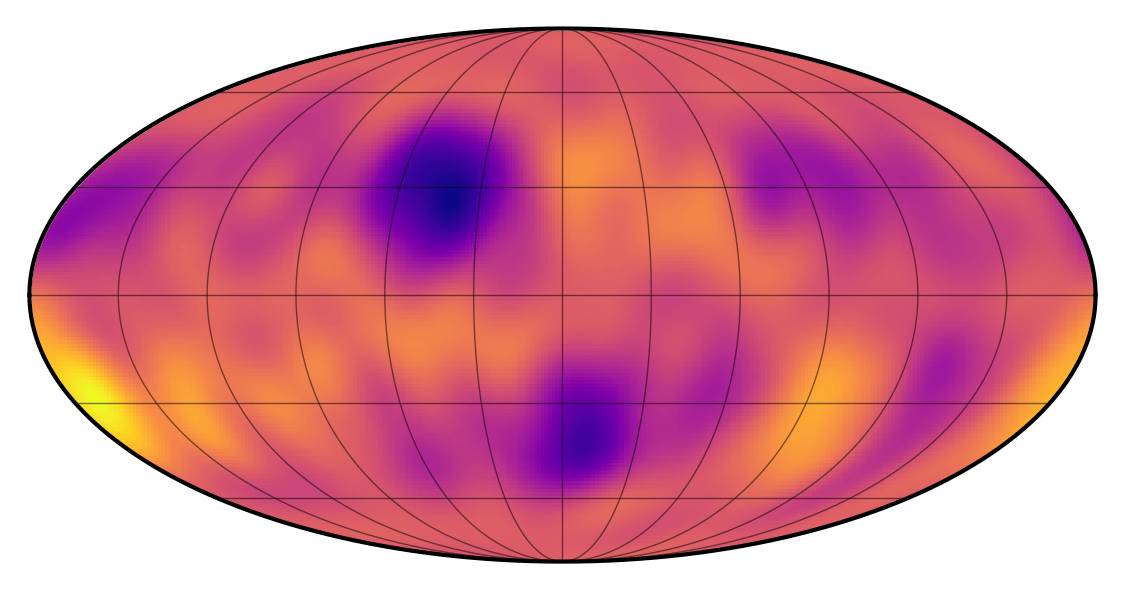

In [10]:
sp.visualize(y_true)

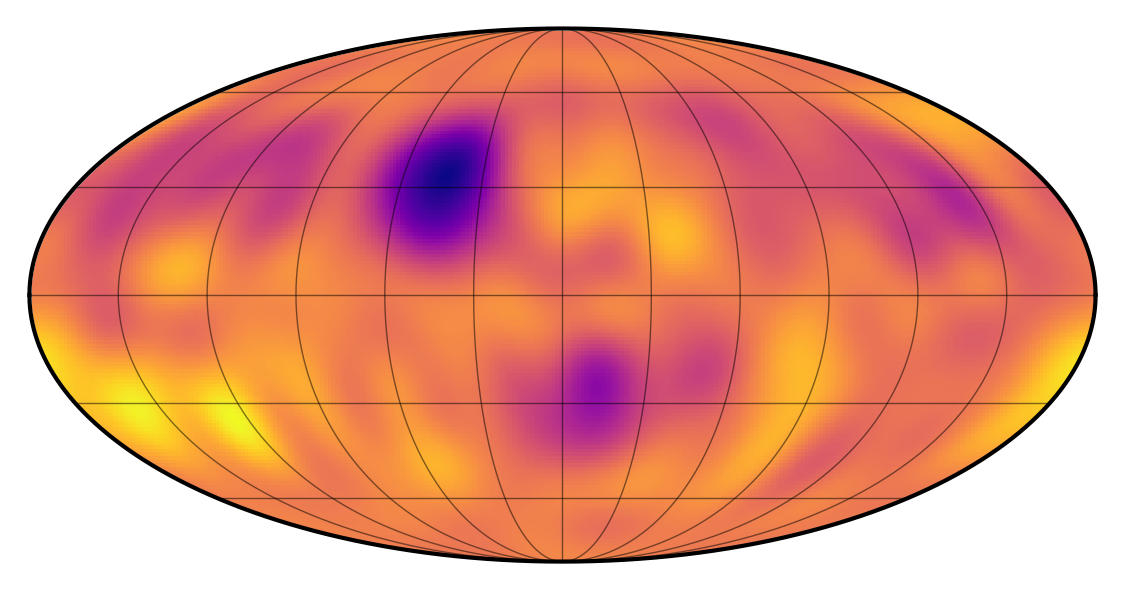

In [11]:
sp.visualize(ylm_draw)

Pre-computing some matrices... Done.


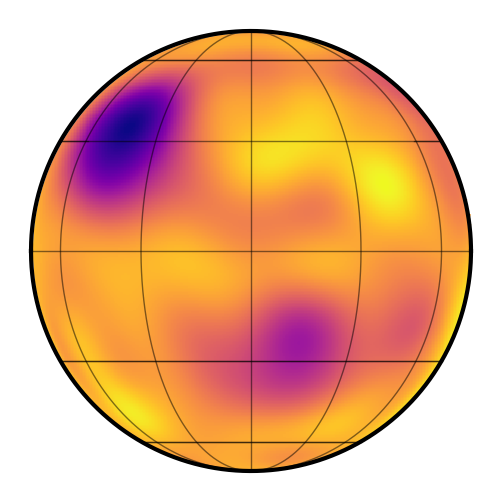

In [30]:
map_draw = starry.Map(ydeg, udeg=udeg)
map[:,:] = ylm_draw
map.show()

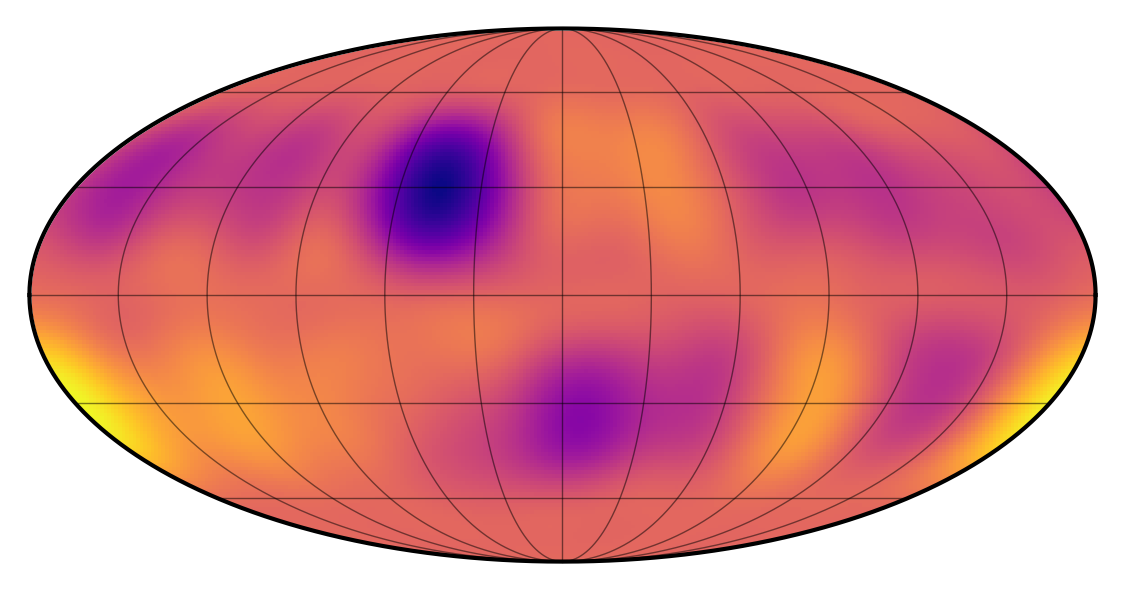

In [12]:
sp.visualize(ssp.a.eval())

Let's double-check the Gaussian factorization; the next two cells should give identical log-likelihoods:

In [13]:
r = flux_obs - ssp.design_matrix.eval() @ ylm_draw
np.sum(ss.norm(loc=0, scale=sigma_flux).logpdf(r)) - 0.5*np.dot(ylm_draw[1:] - sp.mean_ylm.eval()[1:], np.linalg.solve(sp.cov_ylm.eval()[1:,1:], ylm_draw[1:] - sp.mean_ylm.eval()[1:])) - 0.5*np.linalg.slogdet(sp.cov_ylm.eval()[1:,1:])[1] - 0.5*(len(ylm_draw)-1)*np.log(2*np.pi)

389489.258658511

In [14]:
ssp.marginal_likelihood(t, flux_obs, sigma_flux).eval() - 0.5*np.dot(ylm_draw - ssp.a.eval(), sl.cho_solve((ssp.A_chol.eval(), True), ylm_draw - ssp.a.eval())) - np.sum(np.log(np.diag(ssp.A_chol.eval()))) - 0.5*len(ylm_draw)*np.log(2*np.pi)

-1059501.3286533335


389489.258660735

In [15]:
ssp.marginal_likelihood(t, flux_obs, sigma_flux).eval()

-1059501.3286533335


array(387914.23435559)

In [16]:
ssp.marginal_likelihood_wsm(t, flux_obs, sigma_flux).eval()

-1059516.5369876313


ValueError: Shape mismatch: A.shape[1] != x.shape[0]
Apply node that caused the error: CGemv{inplace}(AllocEmpty{dtype='float64'}.0, TensorConstant{1.0}, InplaceDimShuffle{1,0}.0, CGemv{inplace}.0, TensorConstant{0.0})
Toposort index: 375
Inputs types: [TensorType(float64, vector), TensorType(float64, scalar), TensorType(float64, matrix), TensorType(float64, vector), TensorType(float64, scalar)]
Inputs shapes: [(255,), (), (255, 255), (256,), ()]
Inputs strides: [(8,), (), (8, 2048), (8,), ()]
Inputs values: ['not shown', array(1.), 'not shown', 'not shown', array(0.)]
Outputs clients: [[Solve{A_structure='general', lower=False, overwrite_A=False, overwrite_b=False}(Gemm{no_inplace}.0, CGemv{inplace}.0)]]

HINT: Re-running with most Theano optimization disabled could give you a back-trace of when this node was created. This can be done with by setting the Theano flag 'optimizer=fast_compile'. If that does not work, Theano optimizations can be disabled with 'optimizer=None'.
HINT: Use the Theano flag 'exception_verbosity=high' for a debugprint and storage map footprint of this apply node.

In [61]:
with pm.Model() as model:

    starry.config.lazy = True

    sp = StarryProcess(n=n, mu=mu, sigma=sigma, r=20, dr=dr, ydeg=ydeg, udeg=udeg, marginalize_over_inclination=False)  

    ssp = StarryStarryProcess(sys, sp, nt, len(pri.map.y.eval()))

    y_model = ssp.sample_ylm_conditional(t, flux_obs, sigma_flux)[0,:]

    pm.Deterministic('y_draw', y_model)

    map_model = starry.Map(ydeg=15, udeg=2)
    map_model[:,:] = y_model.eval().reshape(-1)

    rp = pm.Uniform('rp',lower=0.199, upper=0.21)
    porb = pm.Uniform('porb',lower=4.88, upper=4.8878)
    t0 = pm.Uniform("t0",lower=0.0, upper=0.00000001)

    pri = Primary(starry.Map(ydeg, udeg=udeg),
              r=0.683, m=0.81, prot=30.0, t0=0.0)
    sec = Secondary(starry.Map(0, 0), 
                    t0=t0, r=rp, m=0.1, prot=1.0,
                    porb=4.887802443, ecc=0.0, Omega=30.0)
    pri.map[1] = u1
    pri.map[2] = u2

    sys = System(pri, sec)

    # flux_model, flux_p = sys.flux(t, total=False)
    # flux_model = map_model.flux(theta=theta, xo=xo, yo=yo, zo=zo, ro=rp)
    flux_model = tt.dot(sys.design_matrix(t)[:, :-1], y_model)

    pm.Deterministic("lc_model", flux_model)

    # The likelihood function assuming known Gaussian uncertainty
    pm.Normal("obs", mu=flux_model, sd=sigma_flux, observed=flux_obs)

Pre-computing some matrices... Done.
Pre-computing some matrices... Done.
Pre-computing some matrices... Done.


In [62]:
with model:
    soln = pmx.optimize(options=dict(maxiter=9999))
    y_model = np.array(soln["y_draw"])
    flux_model = soln["lc_model"]

message: Optimization terminated successfully.
logp: 387410.49897639913 -> 387970.13780359924


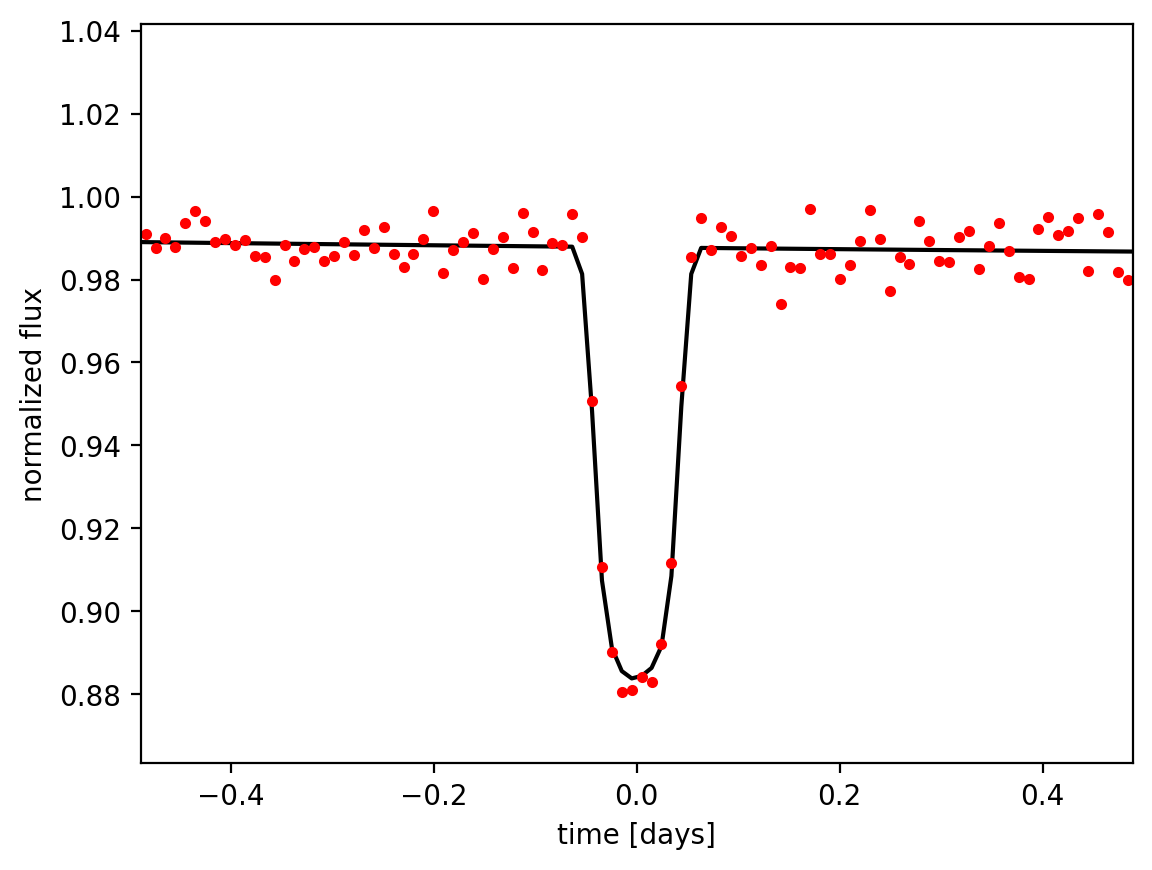

In [63]:
plt.plot(t, flux_model, 'k')
plt.plot(t, flux_obs, 'r.')
plt.xlabel("time [days]")
plt.ylabel("normalized flux");
plt.xlim(-sec.porb.eval()/10, sec.porb.eval()/10)
plt.show()


Pre-computing some matrices... Done.
Compiling `render`... Done.


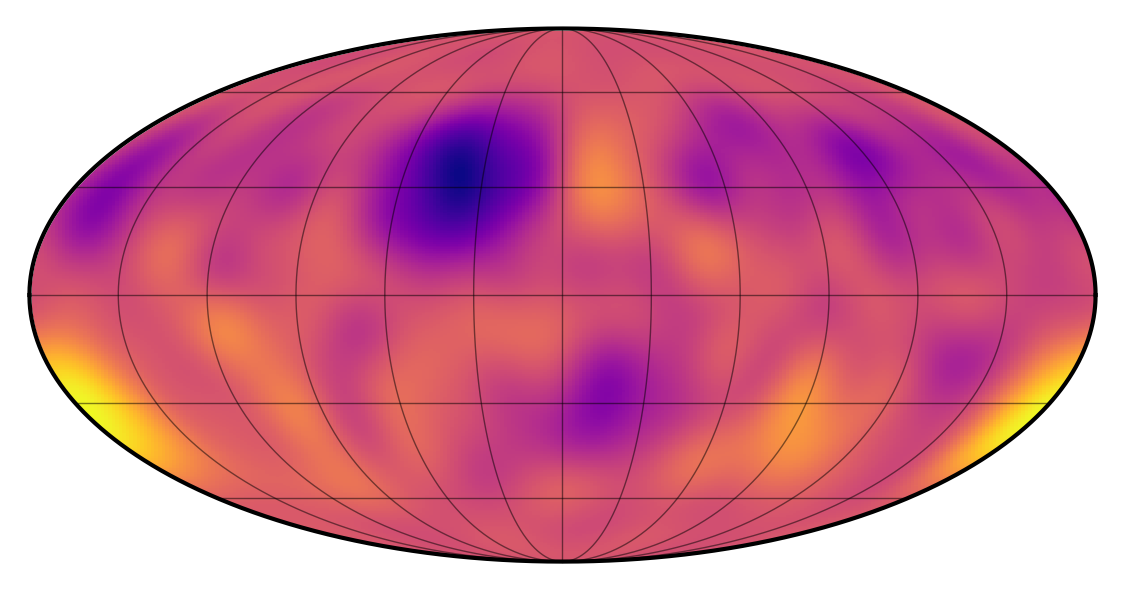

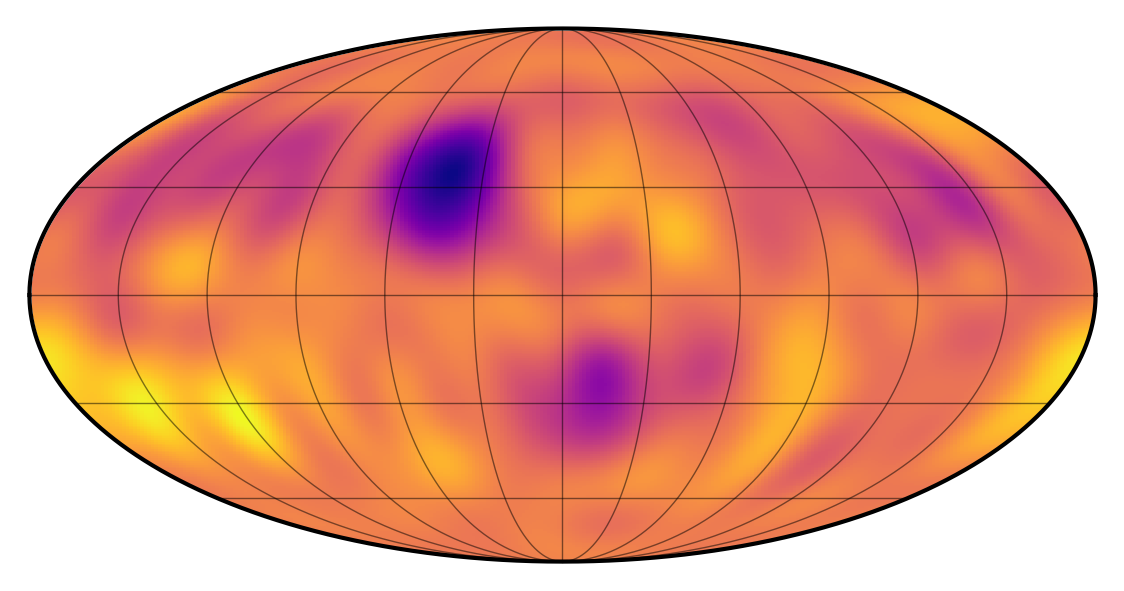

In [64]:
map_inf = starry.Map(ydeg=15, udeg=2)
map_inf[:,:] = y_model.reshape(-1)
map_inf.show(projection="moll")
map.show(projection="moll")

(-0.4887802443, 0.4887802443)

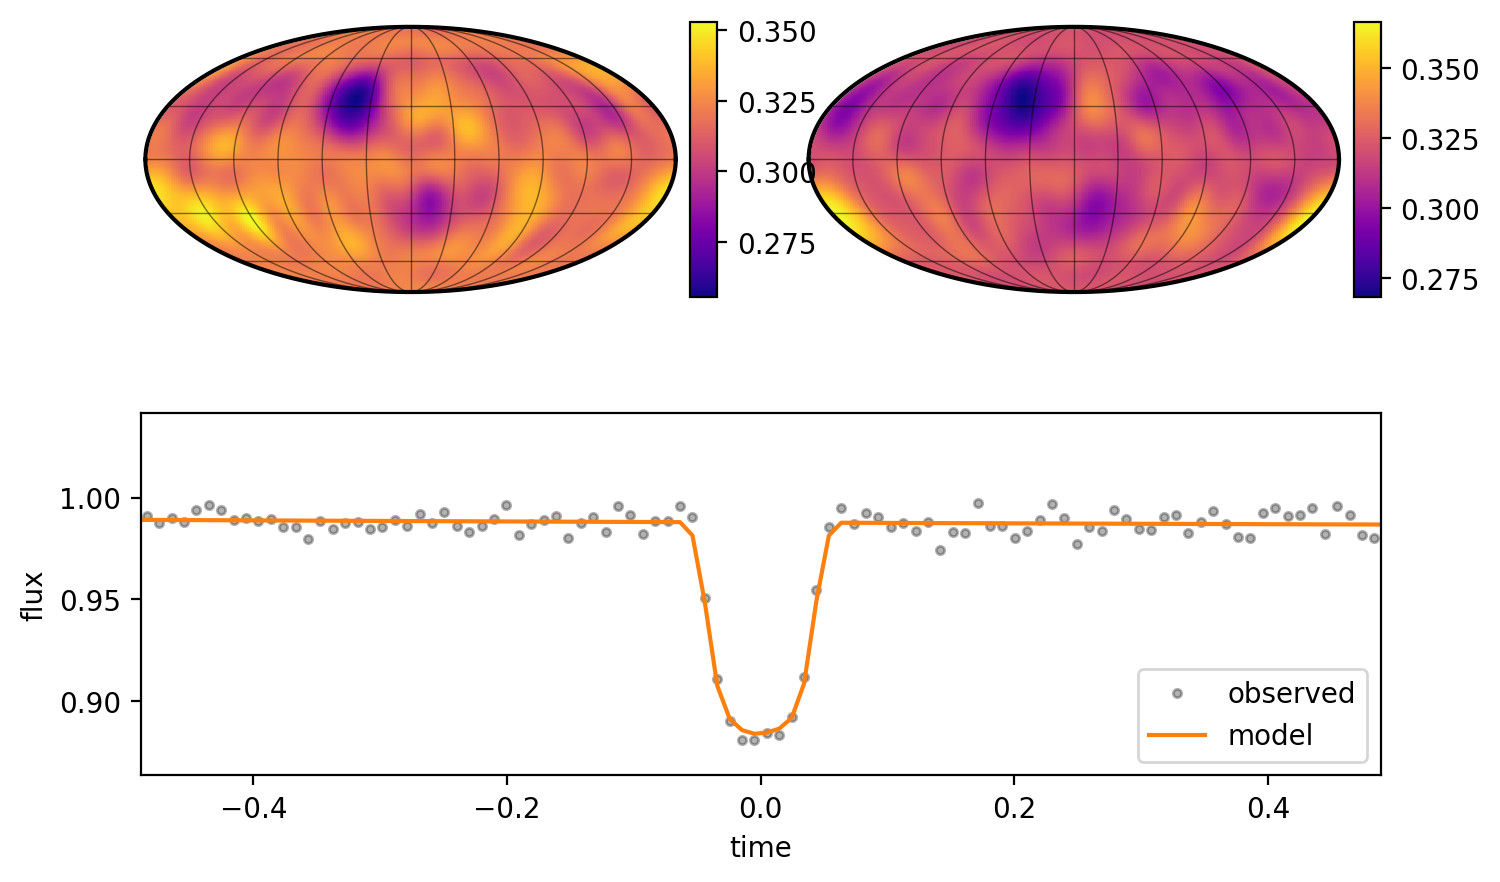

In [65]:
from matplotlib import colors
cmap = plt.get_cmap("plasma")
cmap.set_under("#666666")
cmap.set_over("w")
cnorm = lambda: colors.Normalize(vmin=0.0)
fig = plt.figure(figsize=(8, 8))
fig.subplots_adjust(wspace=0.15)
ax = [
    plt.subplot2grid((3, 2), (0, 0), colspan=1, rowspan=1),
    plt.subplot2grid((3, 2), (0, 1), colspan=1, rowspan=1),
    plt.subplot2grid((3, 2), (1, 0), colspan=2, rowspan=1),
]

# Show the true map
map.show(
    ax=ax[0],
    projection="moll",
    colorbar=True,
    #norm=cnorm()
)

# Show the inferred map
map_inf.show(
    ax=ax[1],
    projection="moll",
    colorbar=True,
    #norm=cnorm()
)

# Show the flux model
ax[2].plot(t, flux_obs, "k.", alpha=0.3, label="observed")
ax[2].plot(t, flux_model, "C1", label="model")
ax[2].legend(fontsize=10, loc="lower right")
ax[2].set_xlabel("time")
ax[2].set_ylabel("flux")
ax[2].set_xlim(-sec.porb.eval()/10, sec.porb.eval()/10)